In [3]:
import torch.nn as nn
import torch, torch.optim
import torchvision.transforms as transform
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim import lr_scheduler
from torchvision.transforms.functional import to_tensor
from torch.utils.data import TensorDataset, DataLoader
import torchvision.models as models

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt # For displaying images
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


In [4]:
torch.manual_seed(42)
np.random.seed(42)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rm1000/brain-tumor-mri-scans")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-scans


In [7]:
import os
import cv2
import numpy as np

# Define the base path to your dataset
dataset_base_path = '/kaggle/input/brain-tumor-mri-scans'

# List of your class names (folder names)
class_names = [ 'glioma','healthy', 'meningioma', 'pituitary']

# Initialize lists to store image data and corresponding labels
all_images = []
all_labels = []

# Define the target size for resizing images
TARGET_SIZE = (128, 128) # As you used in your code

print("--- Step 1: Loading and Resizing Images ---")

# Loop through each class (folder)
for class_name in class_names:
    # Construct the full path to the class folder
    class_folder_path = os.path.join(dataset_base_path, class_name)
    print(f"Processing folder: {class_folder_path}")

    # Check if the folder exists
    if not os.path.exists(class_folder_path):
        print(f"Warning: Folder '{class_folder_path}' not found. Skipping.")
        continue

    # Loop through each item in the current class folder
    for item_name in os.listdir(class_folder_path):
        item_path = os.path.join(class_folder_path, item_name)

        # Check if the item is a file and ends with an image extension
        if os.path.isfile(item_path) and item_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            image = cv2.imread(item_path, 0) # Read in grayscale (0)

            if image is not None:
                # Resize the image to the TARGET_SIZE
                image = cv2.resize(image, TARGET_SIZE)
                image = image / 255.0  # Normalize to [0, 1]
                image = image.astype(np.float32)
                # Add a channel dimension for grayscale images (height, width, 1)
                image = np.expand_dims(image, axis=-1)
                all_images.append(image)
                all_labels.append(class_name)
            else:
                print(f"Warning: Could not load image {item_path}. Skipping.")
        else:
            # Optionally, you can add a print statement here to see what non-image files are being skipped
            # print(f"Skipping non-image file/folder: {item_path}")
            pass

print(f"\nLoaded {len(all_images)} images.")
print(f"Loaded {len(all_labels)} labels.")

# You can now convert all_images and all_labels to NumPy arrays
# For further processing like training an ML model
all_images_np = np.array(all_images)
all_labels_np = np.array(all_labels)

print(f"Shape of image array: {all_images_np.shape}")
print(f"Shape of label array: {all_labels_np.shape}")

--- Step 1: Loading and Resizing Images ---
Processing folder: /kaggle/input/brain-tumor-mri-scans/glioma
Processing folder: /kaggle/input/brain-tumor-mri-scans/healthy
Processing folder: /kaggle/input/brain-tumor-mri-scans/meningioma
Processing folder: /kaggle/input/brain-tumor-mri-scans/pituitary

Loaded 7023 images.
Loaded 7023 labels.
Shape of image array: (7023, 128, 128, 1)
Shape of label array: (7023,)


In [8]:
X = all_images_np
y = all_labels_np
X.dtype

dtype('float32')

In [9]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

if X_train.dim() == 3:
        X_train = X_train.unsqueeze(1)
if X_test.dim() == 3:
        X_test = X_test.unsqueeze(1)


X_train = X_train.permute(0, 3, 1, 2) # Becomes (N, 1, H, W)
X_test = X_test.permute(0, 3, 1, 2)   # Becomes (N, 1, H, W)

print(X_train.shape)
print(X_test.shape)


 # --- Create PyTorch DataLoaders ---
batch_size = 64 # Define your desired batch size



torch.Size([5618, 1, 128, 128])
torch.Size([1405, 1, 128, 128])


In [10]:
import torchvision.transforms as transforms
# In a new cell before defining transforms:
# Calculate mean and std from the training data
# Note: X_train is (N, C, H, W) where C=1

# Ensure X_train is on CPU for numpy operations if it's on GPU
X_train_cpu = X_train.cpu().numpy()

# Normalize the raw data to [0, 1] first if not already
# In your case, it's already done before converting to tensor (image = image / 255.0)
# So, we'll use the [0,1] scaled data directly.

mean = X_train_cpu.mean()
std = X_train_cpu.std()

print(f"Calculated Mean: {mean:.4f}, Std: {std:.4f}")

# Update your transforms with these calculated values
# For grayscale, it's a list with one value: [mean], [std]
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10), # Added
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])


Calculated Mean: 0.1868, Std: 0.2030


In [12]:
class CustomTensorDataset(TensorDataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        # Apply transform if provided
        if self.transform:
            # transforms.ToPILImage expects (C, H, W) or (H, W, C) input.
            # Your X_train/X_test are (N, 1, H, W). Squeeze the channel for ToPILImage.
            # Then unsqueeze it back after ToTensor().
            x = self.transform(x.squeeze(0)) # Squeeze channel dimension for ToPILImage
             # Add channel dimension back if ToTensor removes it for grayscale

        return x, y

    def __len__(self):
        return len(self.data)

# Create TensorDatasets with the transforms
train_dataset = CustomTensorDataset(X_train, y_train, transform=train_transform)
test_dataset = CustomTensorDataset(X_test, y_test, transform=test_transform)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Shapes after creating DataLoaders (first batch example):")
for images, labels in train_loader:
    print(f"Train Batch Image Shape: {images.shape}, Labels Shape: {labels.shape}")
    break
for images, labels in test_loader:
    print(f"Test Batch Image Shape: {images.shape}, Labels Shape: {labels.shape}")
    break

Shapes after creating DataLoaders (first batch example):
Train Batch Image Shape: torch.Size([64, 1, 128, 128]), Labels Shape: torch.Size([64])
Test Batch Image Shape: torch.Size([64, 1, 128, 128]), Labels Shape: torch.Size([64])


In [13]:
class BrainTumorResNet(nn.Module):
    """
    A Convolutional Neural Network (CNN) for classifying brain MRI scans
    into different tumor types (or healthy), leveraging a pre-trained ResNet model.

    Input: Grayscale images of size (Batch_Size, 1, 128, 128)
    Output: Logits for 4 classes (glioma, healthy, meningioma, pituitary)

    Strategy: Transfer Learning (Fine-tuning)
    - Loads a pre-trained ResNet model (e.g., ResNet18).
    - Modifies the first convolutional layer to accept 1 grayscale channel.
    - Replaces the final fully connected layer to output 'num_classes'.
    - Offers an option to freeze early layers for initial feature extraction.
    """
    def __init__(self, num_classes=4, model_name='resnet18', freeze_features=True):
        """
        Initializes the ResNet-based CNN.

        Args:
            num_classes (int): The number of output classes for classification.
            model_name (str): Specifies which ResNet model to use ('resnet18', 'resnet34', 'resnet50').
                              ResNet18 is often a good starting point for transfer learning.
            freeze_features (bool): If True, freezes the weights of the pre-trained
                                    feature extractor layers. Only the new classification
                                    head and potentially the modified conv1 will be trained.
                                    If False, all layers will be fine-tuned.
        """
        super(BrainTumorResNet, self).__init__()

        # 1. Load a pre-trained ResNet model based on model_name
        if model_name == 'resnet18':
            self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        elif model_name == 'resnet34':
            self.resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        elif model_name == 'resnet50':
            self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        else:
            raise ValueError("Unsupported ResNet model_name. Choose from 'resnet18', 'resnet34', 'resnet50'.")

        # 2. Modify the first convolutional layer for grayscale input (1 channel)
        # Original ResNet expects 3 input channels (RGB).
        # We need to change it to accept 1 input channel (grayscale).
        original_conv1 = self.resnet.conv1
        self.resnet.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=original_conv1.out_channels,
            kernel_size=original_conv1.kernel_size,
            stride=original_conv1.stride,
            padding=original_conv1.padding,
            bias=original_conv1.bias # Keep bias if original had it
        )
        # Initialize the new conv1 weights by averaging the original 3-channel weights.
        # This helps leverage some of the pre-trained knowledge for grayscale input.
        with torch.no_grad(): # Perform this operation without tracking gradients
            self.resnet.conv1.weight.copy_(original_conv1.weight.mean(dim=1, keepdim=True))


        # 3. Freeze all parameters in the feature extractor (optional, based on `freeze_features`)
        if freeze_features:
            for name, param in self.resnet.named_parameters():
                if "fc" not in name and "conv1" not in name: # Don't freeze fc and new conv1
                    param.requires_grad = False
            print(f"Frozen pre-trained {model_name} features (except fc and conv1).")
            print("Only the final layer and the modified conv1 layer will be trained initially.")
        else:
            # If not freezing, a smaller initial learning rate is usually best.
            print(f"All {model_name} layers will be fine-tuned. Consider a very small learning rate.")

        # 4. Replace the final fully connected layer (classifier)
        # ResNet's final layer is `fc`. Get the number of input features to the original fc layer.
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes) # New fully connected layer

        # You can add a dropout layer here if desired, before the final fc layer
        # It's common to have it in the classification head, especially if not fine-tuning
        self.dropout = nn.Dropout(0.4) # Example: added dropout

    def forward(self, x):
        """
        Defines the forward pass of the CNN.

        Args:
            x (torch.Tensor): The input tensor (image batch) of shape (N, 1, H, W).

        Returns:
            torch.Tensor: The output logits for each class.
        """
        # Pass the input through the modified ResNet model
        x = self.resnet(x)
        x = self.dropout(x) # Apply dropout before final classification
        return x

# --- Example Usage (for testing the model's shape) ---
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Instantiate the model with 4 classes, using ResNet18, initially freezing features
    model = BrainTumorResNet(num_classes=4, model_name='resnet18', freeze_features=True)
    model.to(device)
    print("\nModel Architecture:\n", model)

    # Create a dummy input tensor (batch size of 1, 1 channel, 128x128 image)
    dummy_input = torch.randn(1, 1, 128, 128).to(device)
    print(f"\nDummy input shape: {dummy_input.shape}")

    # Pass the dummy input through the model
    output = model(dummy_input)
    print(f"Output shape (logits for each class): {output.shape}")

    # Calculate and print total trainable parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal Trainable Parameters: {total_params:,}")

    # Example of how to unfreeze layers for fine-tuning after initial training
    # (This would typically happen after a few epochs of training with frozen features)
    # print("\nUnfreezing all layers for fine-tuning...")
    # for param in model.resnet.parameters():
    #     param.requires_grad = True
    # print("All layers are now trainable.")

    # total_params_unfrozen = sum(p.numel() for p in model.parameters() if p.requires_grad)
    # print(f"Total Trainable Parameters (unfrozen): {total_params_unfrozen:,}")


Using device: cuda
Frozen pre-trained resnet18 features (except fc and conv1).
Only the final layer and the modified conv1 layer will be trained initially.

Model Architecture:
 BrainTumorResNet(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1):

In [14]:
model = BrainTumorResNet(num_classes=4)
model.to(device)

Frozen pre-trained resnet18 features (except fc and conv1).
Only the final layer and the modified conv1 layer will be trained initially.


BrainTumorResNet(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [15]:
# Calculate and print total trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal Trainable Parameters: {total_params:,}")


Total Trainable Parameters: 4,723,780


In [16]:
NUM_EPOCHS = 30
# TODO: Define loss function:
criterion = nn.CrossEntropyLoss()
# TODO: Create optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
total_steps = NUM_EPOCHS * len(train_loader)
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, total_steps=total_steps) # Experiment with max_lr

In [19]:
# Re-define the evaluate function if it's not already defined as a standalone function
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate(model, data_loader, criterion, device, class_names): # Added class_names for report
    model.eval()  # Set model to evaluation mode
    total_test_loss = 0.0
    correct_predictions = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    avg_loss = total_test_loss / len(data_loader)
    accuracy = correct_predictions / len(data_loader.dataset)

    # You can choose to print the full report/matrix only at the very end
    # Or for every epoch if you want detailed monitoring
    # For now, we'll return just loss and accuracy from this function
    return avg_loss, accuracy, all_labels, all_predictions # Return all_labels and all_predictions too

In [20]:
model = BrainTumorResNet(num_classes=4, model_name='resnet18', freeze_features=True) # Initial setup for Phase 1
model.to(device)
criterion = nn.CrossEntropyLoss()

Frozen pre-trained resnet18 features (except fc and conv1).
Only the final layer and the modified conv1 layer will be trained initially.



--- Phase 1: Training with frozen features ---
Epoch 1/10 (Phase 1) - Train Loss: 0.6718, Train Acc: 0.6908 | Test Loss: 0.3395, Test Acc: 0.8669 | LR: 0.001000
Epoch 2/10 (Phase 1) - Train Loss: 0.5180, Train Acc: 0.7410 | Test Loss: 0.2044, Test Acc: 0.9203 | LR: 0.001000
Epoch 3/10 (Phase 1) - Train Loss: 0.4713, Train Acc: 0.7640 | Test Loss: 0.2129, Test Acc: 0.9132 | LR: 0.001000
Epoch 4/10 (Phase 1) - Train Loss: 0.5026, Train Acc: 0.7529 | Test Loss: 0.2034, Test Acc: 0.9260 | LR: 0.001000
Epoch 5/10 (Phase 1) - Train Loss: 0.4462, Train Acc: 0.7723 | Test Loss: 0.3657, Test Acc: 0.8797 | LR: 0.001000
Epoch 6/10 (Phase 1) - Train Loss: 0.4745, Train Acc: 0.7528 | Test Loss: 0.3036, Test Acc: 0.8925 | LR: 0.001000
Epoch 7/10 (Phase 1) - Train Loss: 0.4408, Train Acc: 0.7698 | Test Loss: 0.1709, Test Acc: 0.9416 | LR: 0.001000
Epoch 8/10 (Phase 1) - Train Loss: 0.4247, Train Acc: 0.7732 | Test Loss: 0.2374, Test Acc: 0.9231 | LR: 0.001000
Epoch 9/10 (Phase 1) - Train Loss: 0.467

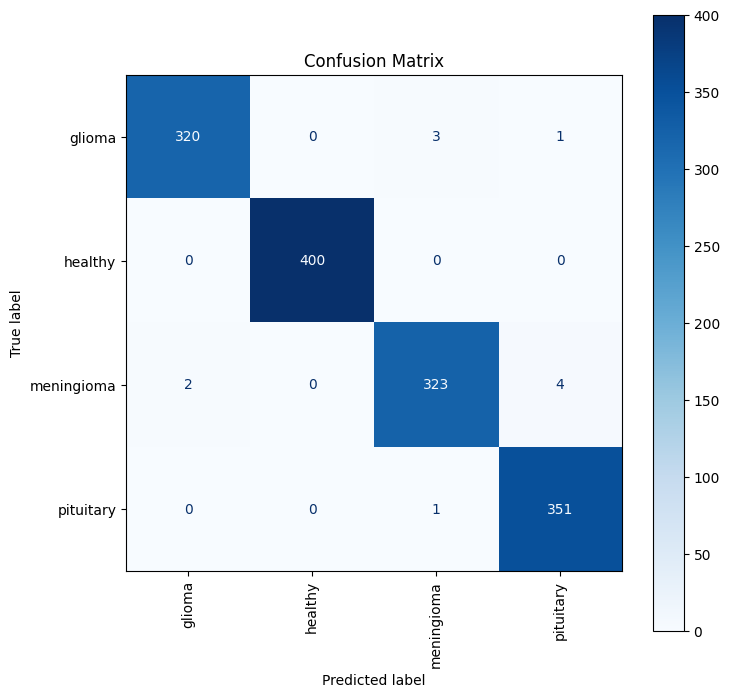


--- Per-Class Accuracies ---
Class 'glioma' (324 samples): 0.9877
Class 'healthy' (400 samples): 1.0000
Class 'meningioma' (329 samples): 0.9818
Class 'pituitary' (352 samples): 0.9972


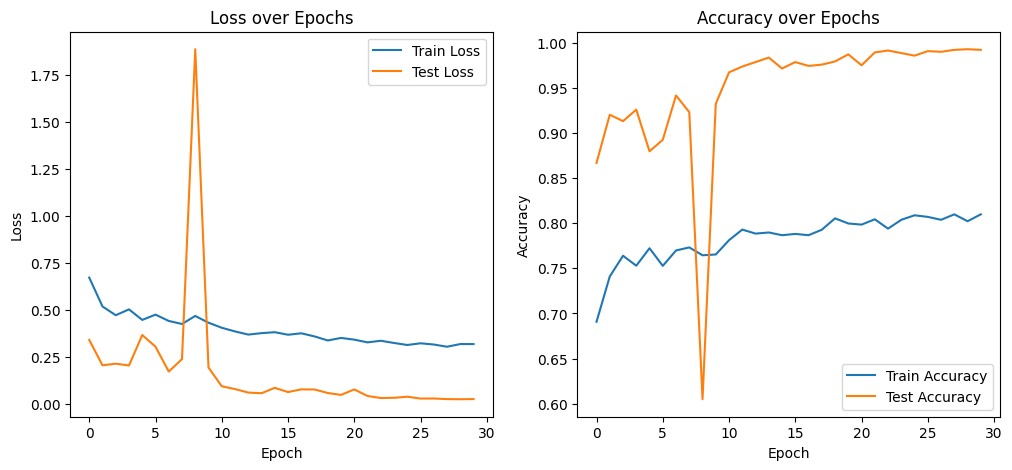

In [21]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# --- Phase 1: Feature Extraction (Frozen Backbone) ---
print("\n--- Phase 1: Training with frozen features ---")
NUM_EPOCHS_PHASE1 = 10 # Start with a few epochs for this phase

# Optimizer for only the trainable parameters (fc and conv1)
optimizer_phase1 = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.001, # Higher LR for new layers
    weight_decay=0.001
)
# Scheduler for Phase 1 (optional, can be fixed LR)
# Using ReduceLROnPlateau based on test_loss (which we will compute inside the loop)
scheduler_phase1 = lr_scheduler.ReduceLROnPlateau(optimizer_phase1, mode='min', factor=0.1, patience=3)

for epoch in range(NUM_EPOCHS_PHASE1):
    model.train() # Set model to training mode
    running_loss = 0.0
    correct_predictions = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer_phase1.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_phase1.step()
        # No scheduler.step() per batch for OneCycleLR here unless you explicitly want that behavior.
        # For ReduceLROnPlateau, you step per epoch with validation loss.

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = correct_predictions / len(train_loader.dataset)

    # Evaluate on test set after each epoch in Phase 1
    epoch_test_loss, epoch_test_accuracy, _, _ = evaluate(model, test_loader, criterion, device, class_names)
    scheduler_phase1.step(epoch_test_loss) # Step based on test loss

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)
    test_losses.append(epoch_test_loss)
    test_accuracies.append(epoch_test_accuracy)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS_PHASE1} (Phase 1) - "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f} | "
          f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_accuracy:.4f} | "
          f"LR: {optimizer_phase1.param_groups[0]['lr']:.6f}")

# --- Phase 2: Fine-tuning (Unfrozen Backbone) ---
print("\n--- Phase 2: Fine-tuning all layers ---")
NUM_EPOCHS_PHASE2 = 20 # Can be more epochs for fine-tuning

# Unfreeze all parameters
for param in model.parameters():
    param.requires_grad = True
print("All model layers are now trainable.")

# Re-initialize optimizer for all parameters with a much smaller LR
optimizer_phase2 = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.001) # Very small LR
# Using OneCycleLR here can be good for fine-tuning, but ensure total_steps is correct
total_steps_phase2 = NUM_EPOCHS_PHASE2 * len(train_loader)
scheduler_phase2 = lr_scheduler.OneCycleLR(optimizer_phase2, max_lr=1e-4, total_steps=total_steps_phase2) # Experiment with max_lr for phase 2

for epoch in range(NUM_EPOCHS_PHASE2):
    model.train() # Set model to training mode
    running_loss = 0.0
    correct_predictions = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer_phase2.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_phase2.step()
        scheduler_phase2.step() # OneCycleLR steps per batch

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = correct_predictions / len(train_loader.dataset)

    # Evaluate on test set after each epoch in Phase 2
    epoch_test_loss, epoch_test_accuracy, _, _ = evaluate(model, test_loader, criterion, device, class_names)

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)
    test_losses.append(epoch_test_loss)
    test_accuracies.append(epoch_test_accuracy)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS_PHASE2} (Phase 2) - "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f} | "
          f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_accuracy:.4f} | "
          f"LR: {optimizer_phase2.param_groups[0]['lr']:.6f}")

print("\nTraining completed!")
print(f"Final Train Loss: {train_losses[-1]:.4f}, Final Train Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}, Final Test Accuracy: {test_accuracies[-1]:.4f}")

# Call evaluate one last time to get the full report and confusion matrix
print("\n--- Final Evaluation on Test Set ---")
test_loss_final, test_accuracy_final, all_labels_final, all_predictions_final = evaluate(model, test_loader, criterion, device, class_names)

print("\n--- Classification Report ---")
print(classification_report(all_labels_final, all_predictions_final, target_names=class_names))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_labels_final, all_predictions_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

print("\n--- Per-Class Accuracies ---")
from collections import Counter
true_counts = Counter(all_labels_final)
for i, class_name in enumerate(class_names):
    class_indices = np.where(np.array(all_labels_final) == i)[0]
    if len(class_indices) == 0:
        print(f"Class '{class_name}': No samples found in test set.")
        continue
    class_predictions = np.array(all_predictions_final)[class_indices]
    class_true_labels = np.array(all_labels_final)[class_indices]
    class_correct = (class_predictions == class_true_labels).sum()
    class_accuracy = class_correct / len(class_indices)
    print(f"Class '{class_name}' ({len(class_indices)} samples): {class_accuracy:.4f}")

# Plotting the results (adjusted to plot both train and test)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()